# Kinetic inverse Ising problem

Consider the Ising model defined on a (directed) random graph with $N$ vertices. The configuration is denoted as $\mathbf{s}=[s_1, s_2, \cdots, s_N]$ and $s_i \in \{-1, +1\}$. The adjacency matrix $A_{ij}=1$ if there is a directed edge from vertex $j$ to vertex $i$. For each vertex, there is a external field $h_i$ associated. For each directed edge, there is a coupling $J_{ij}$ associated and usually $J_{ij}$ is drawn from a Gaussian distribution. The **Glauber dynamics** of Ising spins is defined as follows. At time step $t+1$, the value of spin $i$ is given by the configuration of time step $t$:
$$
p(s_i(t+1)\vert \mathbf{s}(t))=\frac{\exp\{s_i(t+1)\theta_i(t)\}}{2\cosh(\theta_i(t))}
$$
where $\theta_i(t)=\sum_{j\in \partial i} J_{ij}s_j(t)+h_i$ is the effective local field. Usually we will consider the parallel update: all spins are updated synchronously. So the update rule can be written as:
$$
p(\mathbf{s}(t+1)\vert \mathbf{s}(t))=\prod_i p(s_i(t+1)\vert \mathbf{s}(t))
$$

Assume that we obtain time series data $[\mathbf{s}(1), \mathbf{s}(2), \cdots, \mathbf{s}(M)]$ generated by Parallel Glauber dynamics, the **kinetic inverse Ising problem** asks to infer the couplings $\{J_{ij}\}$ and external fields $\{h_i\}$ from the data. See [1] for more details about the Inverse Ising problem.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(2020)
torch.manual_seed(2020)

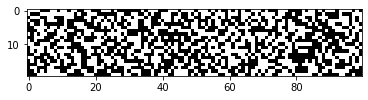

In [2]:
# simulate Glauber dynamics on random graphs with N nodes and connectivity <k>

def generate_random_graph(n, k):
    A_np = np.zeros((n, n))
    for i in range(n):
        candidates = np.delete(np.arange(n), i)
        A_np[i, np.random.choice(candidates, k, replace=False)] = 1.0
    A = torch.from_numpy(A_np).to(torch.float)
    J = A * torch.randn(n, n) / math.sqrt(k)
    return A_np, A, J

class IsingGlauber():
    """Parallel Ising Glauber dynamics"""
    def __init__(self, J, beta=1.0):
        self.n = J.size(0)
        self.J = J
        self.beta = beta

    def one_step_update(self, s):
        theta = torch.matmul(self.J, s)  # local field
        prob = torch.exp(theta) / (2 * torch.cosh(theta))  # p(s_i = +1)
        return torch.bernoulli(prob) * 2 - 1.0

    def simulate(self, realizations=10, time_length=100):
        # generate Glauber dynamics data
        # [R (realizations), T (time length), N (nodes)] 
        self.data = torch.empty(realizations, time_length, self.n)
        for r in range(realizations):
            s = torch.randint(2, size=(self.n, ), dtype=torch.float) * 2 - 1  # initial state
            self.data[r, 0, :] = s
            for t in range(time_length - 1):
                s = self.one_step_update(s)
                self.data[r, t + 1, :] = s
                
num_nodes = 20
connectivity = 4
realizations = 10
time_length = 500

A_np, A, J = generate_random_graph(num_nodes, connectivity)
ising = IsingGlauber(J)
ising.simulate(realizations, time_length+1)
# plot first 100 steps
plt.imshow(ising.data[0, :100, :].T, cmap='gray')

Here we introduce the exact reconstruction method. For parallel Glauber dynamics, the likelihood is
$$
\begin{aligned}
L_{\mathrm{D}}(\boldsymbol{J}, \boldsymbol{h}) &= \frac{1}{M}\sum_{t=1}^{M-1}\ln p(\mathbf{s}(t+1)\vert \mathbf{s}(t)) \\&=
\frac{1}{M}\sum_{t=1}^{M-1}\sum_i[s_t(t+1)\theta_i(t)-\ln 2\cosh(\theta_i(t))]
\end{aligned}
$$

The derivative with respect to couplings and magnetic fields is
$$
\begin{aligned} \frac{\partial L_{\mathrm{D}}}{\partial h_{i}}(\boldsymbol{J}, \boldsymbol{h}) &=\frac{1}{M} \sum_{t=1}^{M-1} \left[s_{i}(t+1)-\operatorname{th} \theta_{i}(t)\right] \\ \frac{\partial L_{\mathrm{D}}}{\partial J_{i j}}(\boldsymbol{J}, \boldsymbol{h}) &=\frac{1}{M} \sum_{t=1}^{M-1}\left[s_{i}(t+1) s_{j}(t)-\operatorname{th}\left(\theta_{i}(t)\right) s_{j}(t)\right] \end{aligned}
$$

Epoch 1000	Error 0.6722
Epoch 2000	Error 0.5070
Epoch 3000	Error 0.4149
Epoch 4000	Error 0.3600
Epoch 5000	Error 0.3271
Epoch 6000	Error 0.3079
Epoch 7000	Error 0.2973
Epoch 8000	Error 0.2922
Epoch 9000	Error 0.2905
Epoch 10000	Error 0.2909


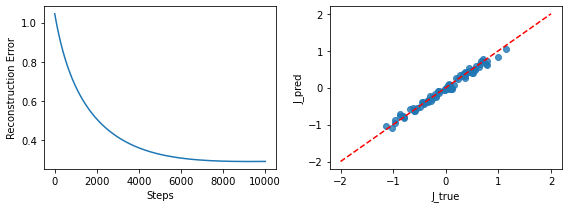

In [3]:
# exact reconstruction

def calc_error(J_true, J_pred):
    n = J_true.size(0)
    return torch.sqrt(torch.sum((J_true - J_pred) ** 2) / n)

data = ising.data[0, :, :] # (time_length, num_nodes)
J_pred = torch.zeros(num_nodes, num_nodes)
epochs = 10000
lr = 1e-3
error_arr = []

# calculate positive phase
positive_phase = torch.empty(num_nodes, num_nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        positive_phase[i, j] = torch.mean(data[1:, i] * data[:-1, j])

for epoch in range(1, epochs+1):
    # calculate negative phase
    negative_phase = torch.empty(num_nodes, num_nodes)
    theta = torch.einsum('ij,tj->ti', J_pred, data)
    for i in range(num_nodes):
        for j in range(num_nodes):
            negative_phase[i, j] = torch.mean(torch.tanh(theta[:, i]) * data[:, j])
    # calculate gradients
    delta_J = positive_phase - negative_phase
    J_pred += lr * delta_J
    error = calc_error(J, J_pred)
    error_arr.append(error)
    if epoch % (epochs // 10) == 0:
        print('Epoch %i\tError %.4f' % (epoch, error))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(error_arr)
plt.xlabel('Steps')
plt.ylabel('Reconstruction Error')
plt.subplot(122)
plt.plot([-2, 2], [-2, 2], 'r--')
plt.scatter(J[torch.nonzero(J, as_tuple=True)], 
            J_pred[torch.nonzero(J_pred * A, as_tuple=True)], alpha=0.8)
plt.xlabel('J_true')
plt.ylabel('J_pred')
plt.tight_layout()

Epoch 2000	Error 0.6724
Epoch 4000	Error 0.5070
Epoch 6000	Error 0.4147
Epoch 8000	Error 0.3596
Epoch 10000	Error 0.3266
Epoch 12000	Error 0.3073
Epoch 14000	Error 0.2968
Epoch 16000	Error 0.2917
Epoch 18000	Error 0.2901
Epoch 20000	Error 0.2905


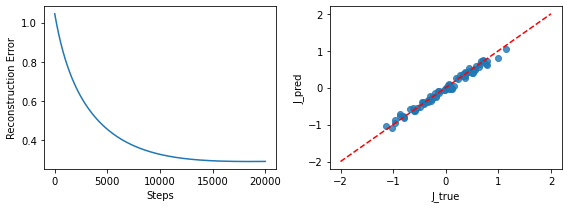

In [4]:
# We can also use autograd to optimize J_ij and h_i
# device = 'cuda:0'
device = 'cpu'
data = ising.data[0, :, :] # (time_length, num_nodes)
data = data.to(device)
J_pred = torch.randn(num_nodes, num_nodes, device=device) * 1e-3
J_pred.requires_grad = True
epochs = 20000
lr = 1e-2
error_arr = []

optimizer = torch.optim.SGD([J_pred], lr=lr)

for epoch in range(1, epochs+1):
    # calculate log likelihood
    optimizer.zero_grad()
    theta = torch.einsum('ij,tj->ti', J_pred, data)
    prob = torch.exp(theta) / (2 * torch.cosh(theta))
    likelihood = torch.mean((1 + data[1:, :]) / 2 * torch.log(prob[:-1, :] + 1e-8) + 
                           (1 - (1 + data[1:, :]) / 2) * torch.log(1 - prob[:-1, :] + 1e-8))
    loss = -1.0 * likelihood
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        error = calc_error(J, J_pred.cpu())
        error_arr.append(error.item())
        if epoch % (epochs // 10) == 0:
            print('Epoch %i\tError %.4f' % (epoch, error))
J_pred = J_pred.data

J_pred = J_pred.cpu().data
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(error_arr)
plt.xlabel('Steps')
plt.ylabel('Reconstruction Error')
plt.subplot(122)
plt.plot([-2, 2], [-2, 2], 'r--')
plt.scatter(J[torch.nonzero(J, as_tuple=True)], 
            J_pred[torch.nonzero(J_pred * A, as_tuple=True)], alpha=0.8)
plt.xlabel('J_true')
plt.ylabel('J_pred')
plt.tight_layout()

Finally we introduce the Naive Mean-Field method to reconstruct the couplings and fields. See [2] for more details. By defining $m_i = <s_i>$, $\chi_{ij}=<s_i s_j>$, $\phi_{ij} = <s_i(t+1)s_j(t)>$ and matrix $D_{ij}=\phi_{ij}-m_i m_j$, $A_{ij}=\delta_{ij}(1-m_i^2)$, $C_{ij}=\chi_{ij}-m_i m_j$, the NMF solution of coupling is simply the matrix inversion:
$$
J^{NMF}=A^{-1}DC^{-1}
$$

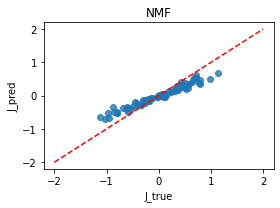

In [5]:
# mean-field solution
# J_nmf = A^{-1} D C^{-1}

data = ising.data[0, :, :] # (time_length, num_nodes)
magnetization = data.mean(0)

chi = torch.empty(num_nodes, num_nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        chi[i, j] = torch.mean(data[:, i] * data[:, j])

phi = torch.empty(num_nodes, num_nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        phi[i, j] = torch.mean(data[1:, i] * data[:-1, j])

D_mat = torch.empty(num_nodes, num_nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        D_mat[i, j] = phi[i, j] - magnetization[i] * magnetization[j]

C_mat = torch.empty(num_nodes, num_nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        C_mat[i, j] = chi[i, j] - magnetization[i] * magnetization[j]
        
A_mat = torch.empty(num_nodes, num_nodes)
for i in range(num_nodes):
    for m in range(num_nodes):
        A_mat[i, m] = (1 - magnetization[i] ** 2) if i == m else 0.

J_pred = torch.inverse(A_mat) @ D_mat @ torch.inverse(C_mat)

plt.figure(figsize=(4, 3))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.scatter(J[torch.nonzero(J, as_tuple=True)], 
            J_pred[torch.nonzero(J_pred * A, as_tuple=True)], alpha=0.8)
plt.xlabel('J_true')
plt.ylabel('J_pred')
plt.title('NMF')
plt.tight_layout()

As we can see, the NMF method underestimates the coupling strength.

Reference:

[1] Nguyen H C, Zecchina R, Berg J. Inverse statistical problems: from the inverse Ising problem to data science[J]. Advances in Physics, 2017, 66(3): 197-261.

[2] Roudi Y, Hertz J. Mean field theory for nonequilibrium network reconstruction[J]. Physical review letters, 2011, 106(4): 048702.